# Peter dan Serigala: Persekitaran Realistik

Dalam situasi kita, Peter dapat bergerak hampir tanpa merasa letih atau lapar. Dalam dunia yang lebih realistik, dia perlu duduk dan berehat dari semasa ke semasa, serta makan untuk mengisi tenaga. Mari kita jadikan dunia kita lebih realistik dengan melaksanakan peraturan berikut:

1. Dengan bergerak dari satu tempat ke tempat lain, Peter kehilangan **tenaga** dan mendapat sedikit **keletihan**.
2. Peter boleh mendapatkan lebih banyak tenaga dengan memakan epal.
3. Peter boleh menghilangkan keletihan dengan berehat di bawah pokok atau di atas rumput (iaitu berjalan ke lokasi papan yang mempunyai pokok atau rumput - padang hijau).
4. Peter perlu mencari dan membunuh serigala.
5. Untuk membunuh serigala, Peter perlu mempunyai tahap tenaga dan keletihan tertentu, jika tidak dia akan kalah dalam pertarungan.


In [1]:
import matplotlib.pyplot as plt
import numpy as np
import random
import math
from rlboard import *

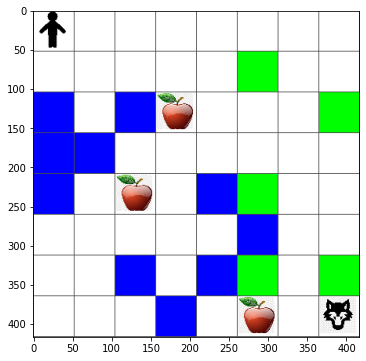

In [2]:
width, height = 8,8
m = Board(width,height)
m.randomize(seed=13)
m.plot()

In [3]:
actions = { "U" : (0,-1), "D" : (0,1), "L" : (-1,0), "R" : (1,0) }
action_idx = { a : i for i,a in enumerate(actions.keys()) }

## Mendefinisikan keadaan

Dalam peraturan permainan baru kita, kita perlu memantau tenaga dan keletihan pada setiap keadaan papan. Oleh itu, kita akan mencipta objek `state` yang akan membawa semua maklumat yang diperlukan tentang keadaan masalah semasa, termasuk keadaan papan, tahap tenaga dan keletihan semasa, dan sama ada kita boleh mengalahkan serigala semasa berada di keadaan terminal:


In [4]:
class state:
    def __init__(self,board,energy=10,fatigue=0,init=True):
        self.board = board
        self.energy = energy
        self.fatigue = fatigue
        self.dead = False
        if init:
            self.board.random_start()
        self.update()

    def at(self):
        return self.board.at()

    def update(self):
        if self.at() == Board.Cell.water:
            self.dead = True
            return
        if self.at() == Board.Cell.tree:
            self.fatigue = 0
        if self.at() == Board.Cell.apple:
            self.energy = 10

    def move(self,a):
        self.board.move(a)
        self.energy -= 1
        self.fatigue += 1
        self.update()

    def is_winning(self):
        return self.energy > self.fatigue

Mari kita cuba menyelesaikan masalah menggunakan jalan rawak dan lihat jika kita berjaya:


In [5]:
def random_policy(state):
    return random.choice(list(actions))

def walk(board,policy):
    n = 0 # number of steps
    s = state(board)
    while True:
        if s.at() == Board.Cell.wolf:
            if s.is_winning():
                return n # success!
            else:
                return -n # failure!
        if s.at() == Board.Cell.water:
            return 0 # died
        a = actions[policy(m)]
        s.move(a)
        n+=1

walk(m,random_policy)

0

In [6]:
def print_statistics(policy):
    s,w,n = 0,0,0
    for _ in range(100):
        z = walk(m,policy)
        if z<0:
            w+=1
        elif z==0:
            n+=1
        else:
            s+=1
    print(f"Killed by wolf = {w}, won: {s} times, drown: {n} times")

print_statistics(random_policy)

Killed by wolf = 5, won: 1 times, drown: 94 times


## Fungsi Ganjaran



In [7]:
def reward(s):
    r = s.energy-s.fatigue
    if s.at()==Board.Cell.wolf:
        return 100 if s.is_winning() else -100
    if s.at()==Board.Cell.water:
        return -100
    return r

## Algoritma Q-Learning

Algoritma pembelajaran sebenar hampir tidak berubah, kita hanya menggunakan `state` dan bukannya hanya kedudukan papan.


In [8]:
Q = np.ones((width,height,len(actions)),dtype=np.float)*1.0/len(actions)

In [9]:
def probs(v,eps=1e-4):
    v = v-v.min()+eps
    v = v/v.sum()
    return v

In [10]:

from IPython.display import clear_output

lpath = []

for epoch in range(10000):
    clear_output(wait=True)
    print(f"Epoch = {epoch}",end='')

    # Pick initial point
    s = state(m)
    
    # Start travelling
    n=0
    cum_reward = 0
    while True:
        x,y = s.board.human
        v = probs(Q[x,y])
        while True:
            a = random.choices(list(actions),weights=v)[0]
            dpos = actions[a]
            if s.board.is_valid(s.board.move_pos(s.board.human,dpos)):
                break 
        s.move(dpos)
        r = reward(s)
        if abs(r)==100: # end of game
            print(f" {n} steps",end='\r')
            lpath.append(n)
            break
        alpha = np.exp(-n / 3000)
        gamma = 0.5
        ai = action_idx[a]
        Q[x,y,ai] = (1 - alpha) * Q[x,y,ai] + alpha * (r + gamma * Q[x+dpos[0], y+dpos[1]].max())
        n+=1

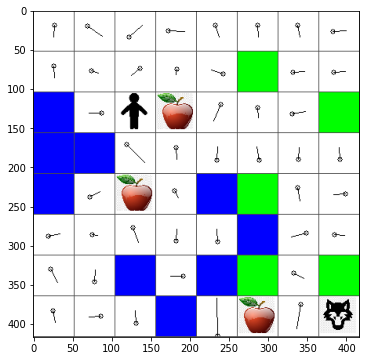

In [11]:
m.plot(Q)

## Keputusan

Mari kita lihat jika kita berjaya melatih Peter untuk melawan serigala!


In [12]:
def qpolicy(m):
        x,y = m.human
        v = probs(Q[x,y])
        a = random.choices(list(actions),weights=v)[0]
        return a

print_statistics(qpolicy)

Killed by wolf = 1, won: 9 times, drown: 90 times


Kami kini melihat jauh lebih sedikit kes kes lemas, tetapi Peter masih tidak selalu dapat membunuh serigala itu. Cuba untuk bereksperimen dan lihat jika anda boleh memperbaiki hasil ini dengan bermain dengan hiperparameter.


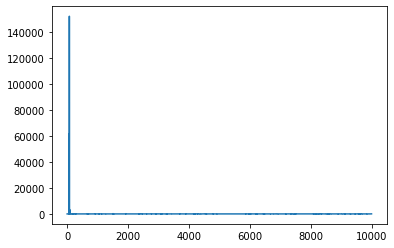

In [13]:
plt.plot(lpath)


---

**Penafian**:  
Dokumen ini telah diterjemahkan menggunakan perkhidmatan terjemahan AI [Co-op Translator](https://github.com/Azure/co-op-translator). Walaupun kami berusaha untuk memastikan ketepatan, sila ambil maklum bahawa terjemahan automatik mungkin mengandungi kesilapan atau ketidaktepatan. Dokumen asal dalam bahasa asalnya harus dianggap sebagai sumber yang berwibawa. Untuk maklumat penting, terjemahan manusia profesional adalah disyorkan. Kami tidak bertanggungjawab atas sebarang salah faham atau salah tafsir yang timbul daripada penggunaan terjemahan ini.
